In [1]:
import soundfile as sf
import numpy as np
import librosa
import os
import cv2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torch.nn as nn
import torch.nn.functional as F

# Audio Detection

- This notebook uses the model trained in the `bounding-box-calssifier.ipynb` notebook to detect spectrograms in audio files.

In [2]:
DATA_PATH = "data"
N_FFT = 512
ENHANCE_FACTOR = 32
TIME_SCALE = 3

## Utils

In [3]:
class SpectrumWindow:
    def __init__(
        self,
        spectrogramSlice: np.ndarray,
        startTime:float,
        endTime:float
    ):
        self.spectrogramSlice = spectrogramSlice
        self.startTime = startTime
        self.endTime = endTime
    
    def __repr__(self):
        return "SpectrumWindow(startTime={}, endTime={}, spectrogramSlice.shape={})".format(self.startTime, self.endTime, self.spectrogramSlice.shape)

In [4]:
def GenerateSpectrogram(audioFileName):
    """
    Generate the spectrogram of the audio file.
    """
    # Read the audio file
    audioData, sampleRate = sf.read(os.path.join(DATA_PATH, audioFileName))
    # Get the total time span of the audio file
    timeSpan = audioData.shape[0] / sampleRate

    # Generate the spectrogram of the audio file
    audioSpectrogram = np.abs(librosa.core.spectrum.stft(audioData, n_fft=N_FFT))

    # Get frequency bins
    spectrogramFrequencies = librosa.core.fft_frequencies(sr=sampleRate, n_fft=N_FFT)

    # Normalize the spectrogram
    audioSpectrogram -= np.amin(audioSpectrogram)
    audioSpectrogram /= np.amax(audioSpectrogram)

    # Preprocess the audio spectrogram for clearer visualization
    audioSpectrogram = 1 - (1-audioSpectrogram)**ENHANCE_FACTOR
    
    return audioSpectrogram, spectrogramFrequencies, timeSpan

In [5]:
def GetAudioWindows(audioSpectrogram: np.ndarray, timeSpan) -> list[SpectrumWindow]:
    """
    Get sliding windows of the audio spectrogram.
    """
    spectrogramHeight = audioSpectrogram.shape[0]
    spectrogramWidth = audioSpectrogram.shape[1]

    audioWindows: list[SpectrumWindow] = []
    sliceIndex = 0
    while True:
        # Get a window of the spectrogram
        startX = sliceIndex * (spectrogramHeight * TIME_SCALE // 2)
        # Break if startX is out of bounds
        if startX >= spectrogramWidth:
            break
        
        # Get the start and end time of the window
        startTime = (startX / spectrogramWidth) * timeSpan
        endTime = (startX + spectrogramHeight * TIME_SCALE) / spectrogramWidth * timeSpan
        
        spectrogramSlice = audioSpectrogram[:, startX:startX+int(spectrogramHeight*TIME_SCALE)]
        # 0-pad the spectrogram slice to make it square
        if spectrogramSlice.shape[1] < int(spectrogramHeight * TIME_SCALE):
            spectrogramSliceTmp = np.zeros((spectrogramHeight, int(spectrogramHeight * TIME_SCALE)))
            spectrogramSliceTmp[:, :spectrogramSlice.shape[1]] = spectrogramSlice
            spectrogramSlice = spectrogramSliceTmp
            
        audioWindow = SpectrumWindow(spectrogramSlice, startTime, endTime)
        audioWindows.append(audioWindow)
        
        sliceIndex += 1
    return audioWindows

In [6]:
class SelectiveSearcher:
    """
    Searcher to perform selective search.
    """
    def __init__(self):
        self.ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    def Search(self, image: np.ndarray, audioWindow: SpectrumWindow) -> list:
        searchTarget = image
        # Convert searchTarget to float32
        searchTarget = searchTarget.astype(np.float32)
        searchTarget.reshape(
            1,
            audioWindow.spectrogramSlice.shape[0],
            audioWindow.spectrogramSlice.shape[1]
        )
        # Convert gray scale image to RGB
        searchTarget = cv2.cvtColor(searchTarget, cv2.COLOR_GRAY2RGB)
        self.ss.setBaseImage(searchTarget)
        self.ss.switchToSelectiveSearchFast()
        # Search
        rects = self.ss.process()
        
        return rects

## Model Setup



In [7]:
# Defining Model
class BoundingBoxClassifier(nn.Module):
    """
    The BoundingBoxClassifier model takes in a spectrogram image and the bounding box metadata as input.
    The spectrogram image size is 64x64.
    The bounding box metadata is a 3-dimensional tensor with start frequency, end frequency, and time span.
    SPECTROGRAM MUST BE FLATTENED TO 1 DIMENSION and COMBINED WITH THE METADATA.
    """
    def __init__(self):
        super().__init__()
        # Input shape is 1x64x64
        # Convolutional layer (1*64*64 -> 16*62*62)
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # Max pooling layer (16*62*62 -> 16*31*31)
        self.pool1 = nn.MaxPool2d(2, 2)
        # Convolutional layer (16*31*31 -> 32*27*27)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        # Max pooling layer (32*27*27 -> 32*9*9)
        self.pool2 = nn.MaxPool2d(3, 3)
        # Fully connected layer (32*9*9 -> 64)
        self.fc1 = nn.Linear(32 * 9 * 9, 64)
        # Hidden layer (64 -> 32)
        self.fc2 = nn.Linear(64, 32)
        # Hidden layer for metadata (3 -> 3)
        self.fc3 = nn.Linear(3, 3)
        # Output layer (32 + 3 -> 1)
        self.out = nn.Linear(32 + 3, 1)
    
    def forward(self, x):
        # Split the x into spectrogram image and bounding box metadata
        # Get the first 1*64*64 tensor
        img = x[:, :1*64*64]
        # Get the last 3 tensor
        metadata = x[:, -3:]
        # Log the metadata to make the values smaller
        metadata += 1
        metadata = torch.log(metadata)
        
        # Reshape the image to (1, 64, 64)
        img = img.reshape(-1, 1, 64, 64)
        
        # Convolutional layer
        x = self.conv1(img)
        x = F.relu(x)
        # Max pooling layer
        x = self.pool1(x)
        # Convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        # Max pooling layer
        x = self.pool2(x)
        # Flatten layer
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        # Hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        
        # Hidden layer for metadata
        metadata = self.fc3(metadata)
        metadata = F.relu(metadata)
        
        # Concatenate the hidden layer and metadata
        x = torch.cat((x, metadata), 1)
        
        # Output layer
        x = self.out(x)
        x = torch.sigmoid(x)
        return x

In [8]:
# Set the model path here
MODEL_PATH = "data\model.pt"

# Load the pretrained model
model = BoundingBoxClassifier()
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

## Audio Detection

In [9]:
TARGET_AUDIO_PATH = "unknown.wav"

# Load audio file
audioSpectrogram, spectrogramFrequencies, timeSpan = GenerateSpectrogram(TARGET_AUDIO_PATH)
audioWindows = GetAudioWindows(audioSpectrogram, timeSpan)

len(audioWindows)

35

In [10]:
class RegionProposal:
    """
    The region proposal for a given audio window.
    """
    def __init__(self, audioWindow: SpectrumWindow, rects: list):
        self.audioWindow = audioWindow
        self.rects = rects

In [11]:
# Selective search
selectiveSearcher = SelectiveSearcher()

proposals: list[RegionProposal] = []
# Traverse all audio windows
for i, audioWindow in enumerate(audioWindows):
    proposal = RegionProposal(
        audioWindow,
        list()
    )
    rects = selectiveSearcher.Search(audioWindow.spectrogramSlice, audioWindow)
    # Traverse all rectangles
    for x, y, w, h in rects:
        # Get the metadata
        startFreq = spectrogramFrequencies[int(y)]
        endFreq = spectrogramFrequencies[min(int(y + h), len(spectrogramFrequencies) - 1)]
        timeSpan = (w / audioWindow.spectrogramSlice.shape[1]) * (audioWindow.endTime - audioWindow.startTime)
        
        metaData = torch.Tensor([startFreq, endFreq, timeSpan])
        metaData = metaData.reshape(1, -1)
        
        # Slice the spectrogram slice
        spectrogramSlice = audioWindow.spectrogramSlice[y:y+h, x:x+w]
        # Reshape the spectrogram slice to 1*w*h
        spectrogramSlice = spectrogramSlice.reshape(spectrogramSlice.shape[0], spectrogramSlice.shape[1], -1)
        # Resize the spectrogram slice to 64x64
        spectrogramSlice = cv2.resize(spectrogramSlice, (64, 64))
        # Convert to float32
        spectrogramSlice = spectrogramSlice.astype(np.float32)
        # Normalize
        spectrogramSlice -= np.amin(spectrogramSlice)
        spectrogramSlice /= np.amax(spectrogramSlice)
        # Reshape to 1x64x64
        spectrogramSlice = spectrogramSlice.reshape(1, -1)
        # Convert to tensor
        spectrogramSlice = torch.from_numpy(spectrogramSlice)
        
        # Combine the spectrogram slice and metadata
        inputs = torch.cat((spectrogramSlice, metaData), 1)
        
        # Predict
        predicted = model(inputs)
        predicted = torch.round(predicted)[0][0]
        # Add the rectangle to the proposal if it is a valid one
        if predicted > 0.5:
            proposal.rects.append((x, y, w, h))
    
    print("Processed {}/{} audio windows, found {} ROIs.".format(
        i, len(audioWindows), len(proposal.rects)
    ))
    proposals.append(proposal)

Processed 0/35 audio windows, found 4 ROIs.
Processed 1/35 audio windows, found 7 ROIs.
Processed 2/35 audio windows, found 4 ROIs.
Processed 3/35 audio windows, found 9 ROIs.
Processed 4/35 audio windows, found 21 ROIs.
Processed 5/35 audio windows, found 25 ROIs.
Processed 6/35 audio windows, found 14 ROIs.
Processed 7/35 audio windows, found 8 ROIs.
Processed 8/35 audio windows, found 14 ROIs.
Processed 9/35 audio windows, found 16 ROIs.
Processed 10/35 audio windows, found 13 ROIs.
Processed 11/35 audio windows, found 11 ROIs.
Processed 12/35 audio windows, found 5 ROIs.
Processed 13/35 audio windows, found 12 ROIs.
Processed 14/35 audio windows, found 28 ROIs.
Processed 15/35 audio windows, found 31 ROIs.
Processed 16/35 audio windows, found 31 ROIs.
Processed 17/35 audio windows, found 17 ROIs.
Processed 18/35 audio windows, found 8 ROIs.
Processed 19/35 audio windows, found 22 ROIs.
Processed 20/35 audio windows, found 34 ROIs.
Processed 21/35 audio windows, found 23 ROIs.
Proce

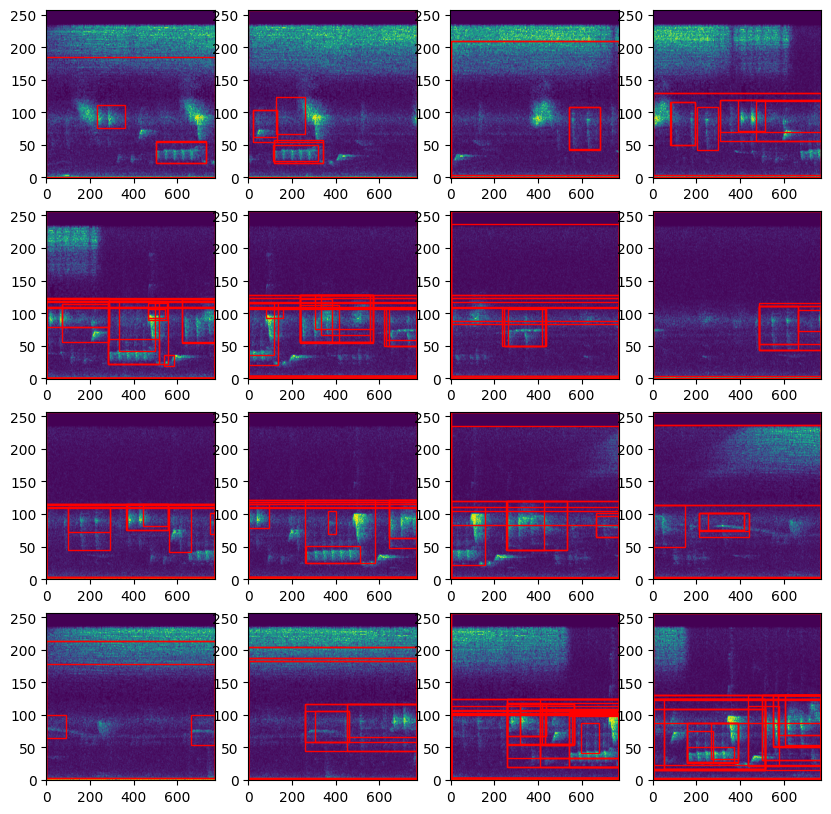

In [13]:
# Draw the proposals
OFFSET = 0
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    proposal = proposals[i  + OFFSET]
    ax[i//4, i%4].imshow(proposal.audioWindow.spectrogramSlice, origin="lower", aspect="auto")
    # Traverse all rectangles
    for x, y, w, h in proposal.rects:
        # Draw the rectangle
        rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax[i//4, i%4].add_patch(rect)
plt.show()